# Kreuzvalidierung

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Daten

In [29]:
df = sns.load_dataset("titanic")

# Model

In [30]:
# Features
features = ["class", "sex", "sibsp", "fare"]
X = df[features]
# Abhängige Variable
y = df["survived"]

X.isnull().any(axis = 1).sum()

0

Daten splitten

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Hyperparaneter-Tuning mit KV

In [32]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV

# Model
tree_clf = DecisionTreeClassifier()

# Parameter-Raum definieren
param_grid = {"max_depth": range(5, 15, 5),
             "min_samples_leaf": range(50, 150, 50),
             "min_samples_split": range(50, 150, 50),
             "criterion": ['gini', 'entropy']}

# Anzahl der Folds in Kreuzvalidierung
n_folds = 5

# Grid Search anlegen
tree_clf_gs = GridSearchCV(estimator = tree_clf,
                          param_grid = param_grid,
                          cv = n_folds,
                          verbose = 1)

# Grid Search ausführen
tree_clf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             verbose=1)

In [33]:
cv_results = pd.DataFrame(tree_clf_gs.cv_results_)
cv_results.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002355,0.000247,0.001381,0.000092,gini,5,50,50,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.776224,0.825175,0.753521,0.767606,0.795775,0.783660,0.024866,9
1,0.002167,0.000084,0.001390,0.000096,gini,5,50,100,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.776224,0.825175,0.753521,0.767606,0.795775,0.783660,0.024866,9
2,0.002150,0.000189,0.001390,0.000099,gini,5,100,50,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.797203,0.811189,0.753521,0.753521,0.823944,0.787876,0.029298,1
3,0.002037,0.000166,0.001296,0.000071,gini,5,100,100,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.797203,0.811189,0.753521,0.753521,0.823944,0.787876,0.029298,1


In [34]:
print(tree_clf_gs.best_estimator_)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=50)


In [35]:
print("Best accuracy: ", round(tree_clf_gs.best_score_, 2))
print('Best Criterion:', tree_clf_gs.best_estimator_.get_params()['criterion'])
print('Best max_depth:', tree_clf_gs.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', tree_clf_gs.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_samples_split:', tree_clf_gs.best_estimator_.get_params()['min_samples_split'])

Best accuracy:  0.79
Best Criterion: gini
Best max_depth: 5
Best min_samples_leaf: 100
Best min_samples_split: 50


Auswahl der optimalen Hyperparameter und Modell mit den gesamten Trainingsdaten erstellen (ohne Kreuzvalidierung)

In [36]:
tree_clf_final = DecisionTreeClassifier(random_state=42,
                                 criterion='gini',
                                 max_depth=5,
                                 min_samples_leaf=100,
                                 min_samples_split=50)

tree_clf_final.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=50,
                       random_state=42)

# Evaluierung mit Testdaten

In [37]:
y_pred = tree_clf_final.predict(X_test)

Fehlermatrix erzeugen:

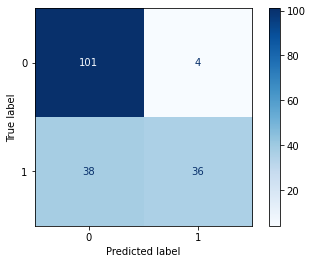

In [38]:
from sklearn import metrics

metrics.plot_confusion_matrix(tree_clf_final, X_test, y_test, cmap=plt.cm.Blues);

In [39]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83       105
           1       0.90      0.49      0.63        74

    accuracy                           0.77       179
   macro avg       0.81      0.72      0.73       179
weighted avg       0.80      0.77      0.75       179



## ROC-Kurve

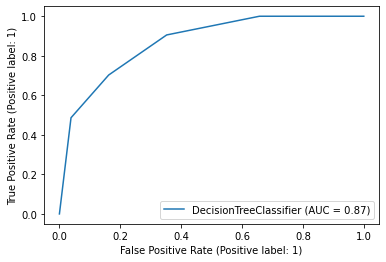

In [40]:
metrics.plot_roc_curve(tree_clf_final, X_test, y_test);  

## Precision-Recall-Kurve

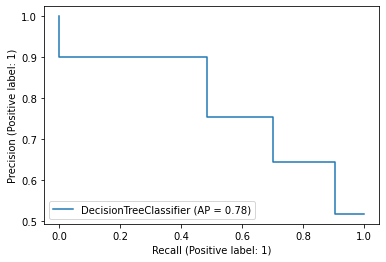

In [41]:
metrics.plot_precision_recall_curve(tree_clf_final, X_test, y_test);

## Kalibrierung

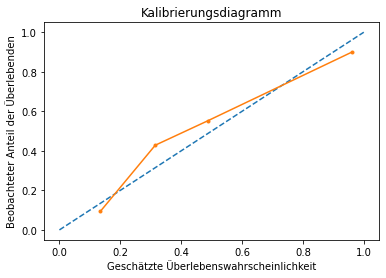

In [42]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

calibrator = CalibratedClassifierCV(tree_clf_final, cv=5)
calibrator.fit(X_train, y_train);

proba_survived = tree_clf_final.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, proba_survived, n_bins=5)

fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], linestyle='--')
ax.plot(prob_pred, prob_true, marker='.')
ax.set_xlabel('Geschätzte Überlebenswahrscheinlichkeit')
ax.set_ylabel('Beobachteter Anteil der Überlebenden')
ax.set_title(r'Kalibrierungsdiagramm');

## Brier Score

In [43]:
survived_prozent = round(sum(y_test)/len(y_test),2)
print("Gesamtanteil der Überlebenden in den Trainingsdaten:", survived_prozent, "\n")

n = len(y_test)
survived_heuristik = np.repeat(survived_prozent, n)  

brier_referenz = metrics.brier_score_loss(y_test, survived_heuristik)
brier_modell = metrics.brier_score_loss(y_test, proba_survived)

print(" Brier-Referenz:", round(brier_referenz, 3), "\n", "Brier-Modell:", round(brier_modell, 3), "\n")

brier_differenz = brier_referenz - brier_modell
skill_score = 100 * ((brier_differenz) / brier_referenz)

print("Der Unterschied zwischen den Brier Scores entspricht ", round(brier_differenz, 3), ", was einer ", round(skill_score, 2), "-prozentigen Verbesserung entspricht", sep="")

Gesamtanteil der Überlebenden in den Trainingsdaten: 0.41 

 Brier-Referenz: 0.243 
 Brier-Modell: 0.146 

Der Unterschied zwischen den Brier Scores entspricht 0.096, was einer 39.74-prozentigen Verbesserung entspricht


Weitere Resourcen:

VanderPlas, J. (2016). Python Data Science Handbook: Essential Tools for Working with Data. O'Reilly Media. [Notebook](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html)